In [1]:
from protest_impact.data.protests.sources.acled import load_acled

acled = load_acled()
acled.head()

,event_date,sub_event_type,assoc_actor_1,admin1,location,notes,region_code,size,weekday
360,2022-12-31,Peaceful protest,Women (Germany),Baden-Württemberg,Freiburg im Breisgau,"On 31 December 2022, a group of individuals de...",BW,NaN,Saturday
361,2022-12-31,Peaceful protest,NaN,Berlin,Berlin - Mitte,"On 31 December 2022, around 300 individuals jo...",BE,300.0,Saturday
362,2022-12-31,Peaceful protest,NaN,Bremen,Bremen,"On 31 December 2022, around 30 individuals joi...",HB,30.0,Saturday
363,2022-12-31,Peaceful protest,NaN,Hamburg,Hamburg - St. Pauli,"On 31 December 2022, a group of about 30 indiv...",HH,30.0,Saturday
364,2022-12-31,Peaceful protest,NaN,Niedersachsen,Lingen,"On 31 December 2022, a group of individuals de...",NI,NaN,Saturday


In [2]:
from protest_impact.data.news.sources.mediacloud import newspapers_by_region

acled = acled[acled["admin1"].isin(newspapers_by_region.keys())]
climate_actors = [
    "FFF: Fridays for Future; Students (Germany)",
    "ALG: Uprising of the Last Generation (Germany)",
    "Extinction Rebellion",
    "Ende Gelaende",
]
acled = acled[acled["assoc_actor_1"].isin(climate_actors)]

<Axes: >

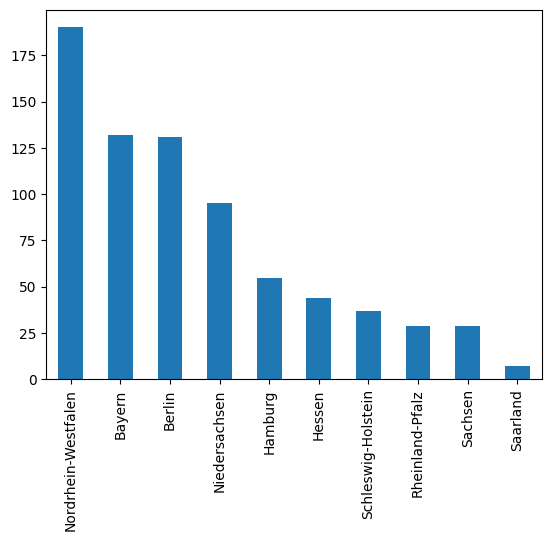

In [3]:
acled["admin1"].value_counts().plot.bar()

['Berlin' 'Brandenburg' 'Bremen' 'Hessen' 'Nordrhein-Westfalen'
 'Rheinland-Pfalz' 'Sachsen-Anhalt' 'Thüringen']


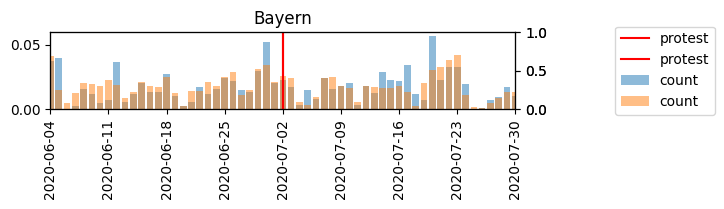

['Berlin' 'Brandenburg' 'Bremen' 'Niedersachsen' 'Rheinland-Pfalz'
 'Saarland' 'Sachsen' 'Sachsen-Anhalt' 'Schleswig-Holstein' 'Thüringen']


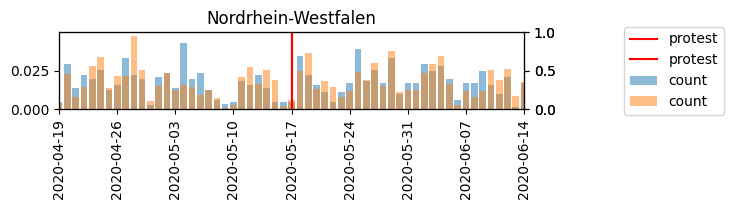

['Brandenburg' 'Bremen' 'Sachsen' 'Sachsen-Anhalt' 'Thüringen']


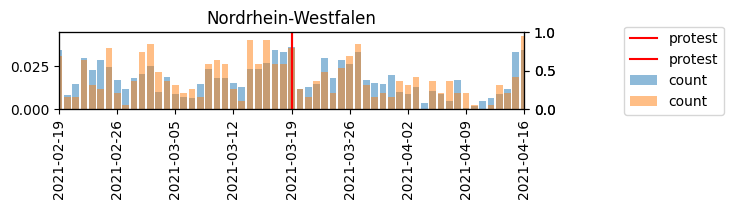

['Berlin' 'Brandenburg' 'Bremen' 'Saarland' 'Sachsen-Anhalt' 'Thüringen']


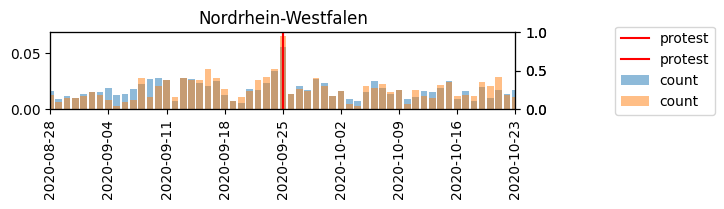

['Brandenburg' 'Bremen' 'Saarland' 'Sachsen-Anhalt' 'Schleswig-Holstein'
 'Thüringen']


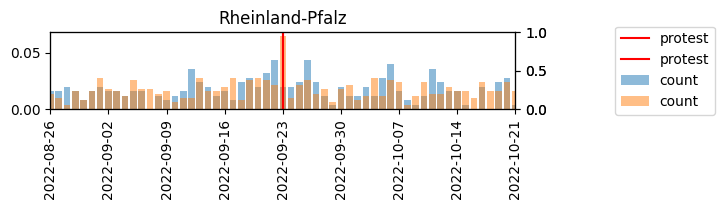

['Bayern' 'Brandenburg' 'Bremen' 'Hamburg' 'Hessen' 'Niedersachsen'
 'Nordrhein-Westfalen' 'Rheinland-Pfalz' 'Saarland' 'Sachsen'
 'Sachsen-Anhalt' 'Schleswig-Holstein' 'Thüringen']


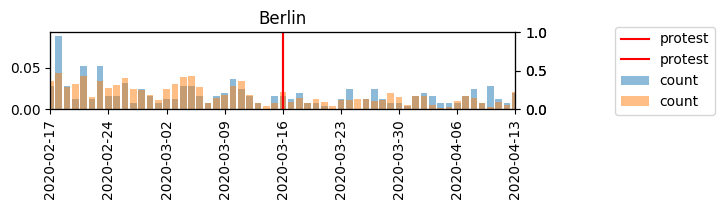

['Brandenburg' 'Bremen' 'Sachsen-Anhalt' 'Thüringen']


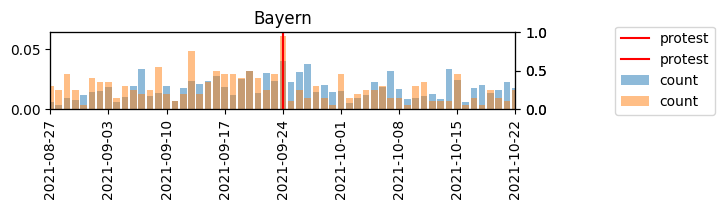

['Brandenburg' 'Bremen' 'Saarland' 'Sachsen-Anhalt' 'Schleswig-Holstein'
 'Thüringen']


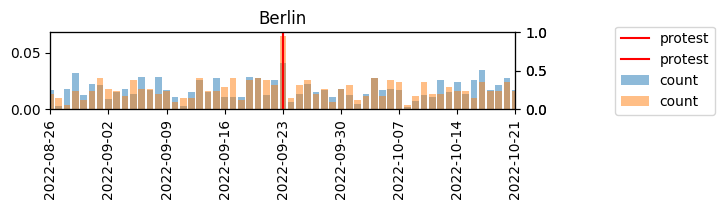

['Bayern' 'Brandenburg' 'Bremen' 'Hessen' 'Niedersachsen'
 'Rheinland-Pfalz' 'Saarland' 'Sachsen' 'Sachsen-Anhalt' 'Thüringen']


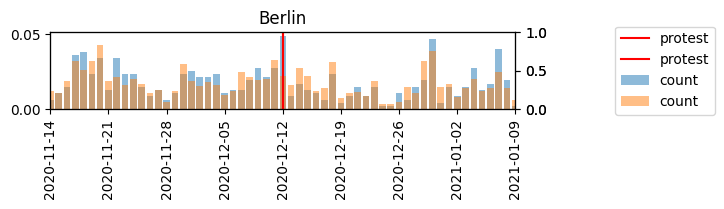

['Brandenburg' 'Bremen' 'Saarland' 'Sachsen-Anhalt' 'Schleswig-Holstein'
 'Thüringen']


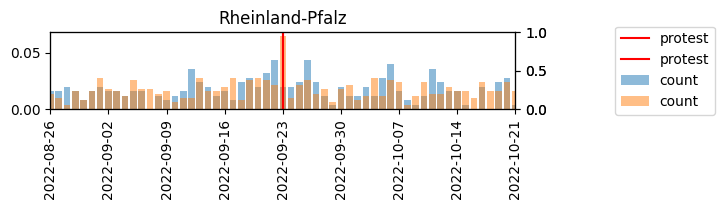

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from dateutil.relativedelta import relativedelta
from protest_impact.data import german_regions
from protest_impact.data.news import get_regional_count_df
from protest_impact.data.news.visual import plot_coverage_sequence

dfs = []
for protest in acled.sample(10, random_state=1).itertuples():
    # # iterate through largest protests
    # for protest in acled.sort_values("size", ascending=False).head(10).itertuples():
    protest_date = protest.event_date
    start_date = protest_date - relativedelta(days=7 * 4)
    end_date = protest_date + relativedelta(days=7 * 4)
    _dfs = []
    for region in [a["name"] for a in german_regions]:
        df = get_regional_count_df(
            "klimaschutz", region, "2019-10-01", "2023-03-01", source="mediacloud"
        )
        if df is None:
            continue
        df = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()
        df["region"] = region
        _dfs.append(df)
    df = pd.concat(_dfs)
    fig, ax = plt.subplots(figsize=(6, 1))
    region_df = df[df["region"] == protest.admin1].copy()
    region_df["count"] = region_df["count"] / region_df["count"].sum()
    plot_coverage_sequence(region_df, title=protest.admin1, ax=ax, alpha=0.5)
    # find other protest events around that day
    other_protests = acled[
        (acled["event_date"] >= protest_date - relativedelta(days=2))
        & (acled["event_date"] <= protest_date + relativedelta(days=2))
    ]
    other_protest_regions = other_protests["admin1"].unique()
    # coverage from regions without protests
    contrast_df = df[~df["region"].isin(other_protest_regions)]
    protestless_regions = contrast_df["region"].unique()
    print(protestless_regions)
    # aggregate by date and take mean
    contrast_df = contrast_df.groupby("date").mean("count").reset_index()
    contrast_df["count"] = contrast_df["count"] / contrast_df["count"].sum()
    plot_coverage_sequence(contrast_df, ax=ax, alpha=0.5)
    plt.show()
    df = df[df["region"].isin([protest.admin1, *protestless_regions])]
    df["is_protest_region"] = df["region"] == protest.admin1
    dfs.append(df)

In [5]:
df = dfs[0]
# pivot by region and date
protest_region = df[df["is_protest_region"]]["region"].unique()[0]
print(protest_region)
df = df.pivot(index="date", columns="region", values="count")
df = df.reset_index()
df.head()

Bayern


region,date,Bayern,Berlin,Brandenburg,Bremen,Hessen,Nordrhein-Westfalen,Rheinland-Pfalz,Sachsen-Anhalt,Thüringen
0,2020-06-04,33,13,4,2,48,23,2,0,0
1,2020-06-05,35,3,2,0,11,16,0,0,1
2,2020-06-06,0,3,0,1,2,5,0,0,0
3,2020-06-07,2,8,1,1,3,14,1,0,0
4,2020-06-08,14,2,1,0,24,14,4,0,0


In [6]:
import math

from sklearn.linear_model import Lasso

split = math.floor(len(df) / 2)
train = df.iloc[:split]
test = df.iloc[split:]
len(train), len(test)

(28, 29)

In [7]:
Y_train = train[protest_region]
X_train = train.drop(columns=[protest_region, "date"])
Y_test = test[protest_region]
X_test = test.drop(columns=[protest_region, "date"])

model = Lasso()
model.fit(X_train, Y_train)
# print intercept and coefficients (annotated with region names)
print(model.intercept_)
for region, coef in zip(X_train.columns, model.coef_):
    print(coef, region)

-1.9131927933349289
-0.07201811572823484 Berlin
0.0 Brandenburg
-0.0 Bremen
0.2394259463260681 Hessen
0.93020195312355 Nordrhein-Westfalen
-0.10175201818652099 Rheinland-Pfalz
-0.0 Sachsen-Anhalt
0.0 Thüringen


In [8]:
df["synth"] = model.predict(df.drop(columns=[protest_region, "date"]))
df.head()

region,date,Bayern,Berlin,Brandenburg,Bremen,Hessen,Nordrhein-Westfalen,Rheinland-Pfalz,Sachsen-Anhalt,Thüringen,synth
0,2020-06-04,33,13,4,2,48,23,2,0,0,29.834158
1,2020-06-05,35,3,2,0,11,16,0,0,1,15.387670
2,2020-06-06,0,3,0,1,2,5,0,0,0,3.000615
3,2020-06-07,2,8,1,1,3,14,1,0,0,11.150015
4,2020-06-08,14,2,1,0,24,14,4,0,0,16.304813


<Axes: title={'center': 'Bayern'}>

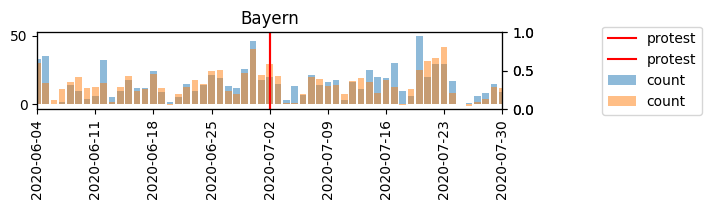

In [9]:
fig, ax = plt.subplots(figsize=(6, 1))
df_region = (
    df[["date", protest_region]].copy().rename(columns={protest_region: "count"})
)
plot_coverage_sequence(df_region, title=protest_region, ax=ax, alpha=0.5)
df_synth = df[["date", "synth"]].copy().rename(columns={"synth": "count"})
plot_coverage_sequence(df_synth, ax=ax, alpha=0.5)

-1.9131927933349289 intercept
-0.07201811572823484 Berlin
0.0 Brandenburg
-0.0 Bremen
0.2394259463260681 Hessen
0.93020195312355 Nordrhein-Westfalen
-0.10175201818652099 Rheinland-Pfalz
-0.0 Sachsen-Anhalt
0.0 Thüringen


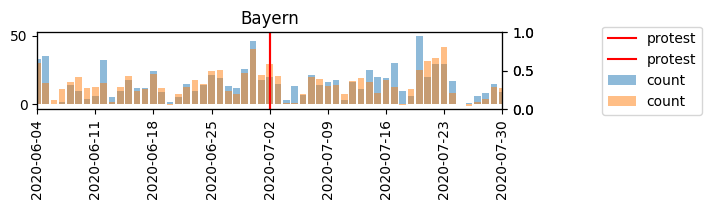

6.584697892371279 intercept
0.6694157604806318 Berlin
0.0 Brandenburg
0.0 Bremen
0.15634352584549754 Niedersachsen
0.9051182477923938 Rheinland-Pfalz
0.0 Saarland
-0.11534202544848084 Sachsen
-0.0 Sachsen-Anhalt
-0.0 Schleswig-Holstein
0.0 Thüringen


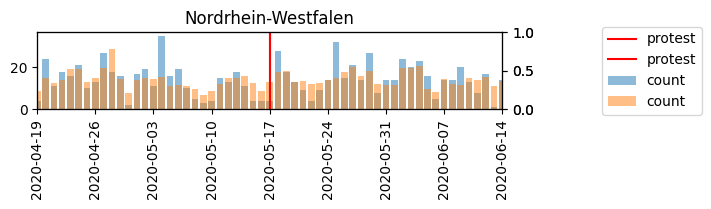

13.18705361092336 intercept
1.7122597038582819 Brandenburg
0.5086619909959876 Bremen
0.8961365716883428 Sachsen
1.0102162745379433 Sachsen-Anhalt
-0.0 Thüringen


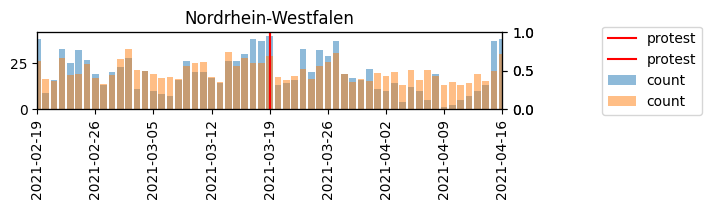

14.128413672436384 intercept
1.2282670934900848 Berlin
0.5571613926989268 Brandenburg
-0.0 Bremen
0.3739709579227709 Saarland
-0.0 Sachsen-Anhalt
0.0 Thüringen


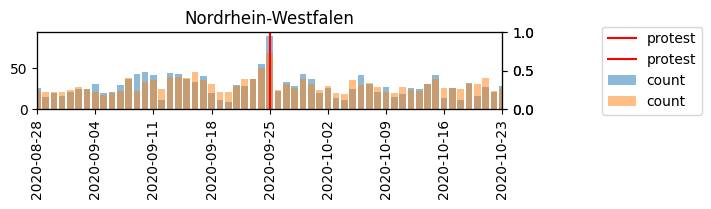

4.4446270128163 intercept
0.008215576733486687 Brandenburg
-0.0 Bremen
0.0 Saarland
0.0 Sachsen-Anhalt
0.0 Schleswig-Holstein
-0.0 Thüringen


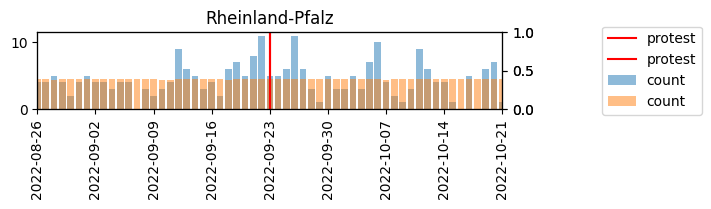

-0.861238068528106 intercept
0.07664933989886066 Bayern
0.0 Brandenburg
-0.0 Bremen
0.5920428395623374 Hamburg
-0.0978287726576399 Hessen
0.13751423603619028 Niedersachsen
0.08514256653998874 Nordrhein-Westfalen
-0.0 Rheinland-Pfalz
0.0 Saarland
0.0 Sachsen
-0.0 Sachsen-Anhalt
0.0 Schleswig-Holstein
-0.0 Thüringen


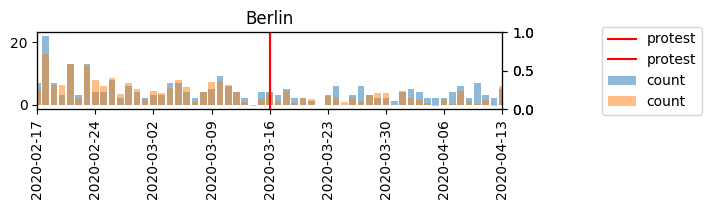

41.13716183150368 intercept
4.131215095620503 Brandenburg
0.0 Bremen
0.0 Sachsen-Anhalt
0.12299712670328858 Thüringen


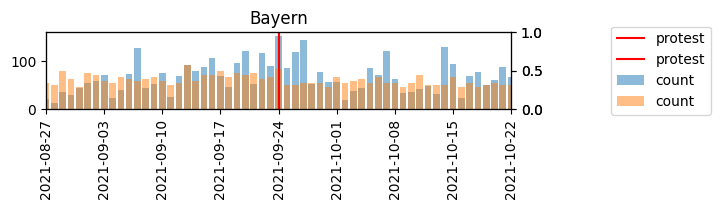

8.782451528097273 intercept
1.2103187643772595 Brandenburg
-0.0 Bremen
-0.0 Saarland
0.0 Sachsen-Anhalt
0.0 Schleswig-Holstein
0.0 Thüringen


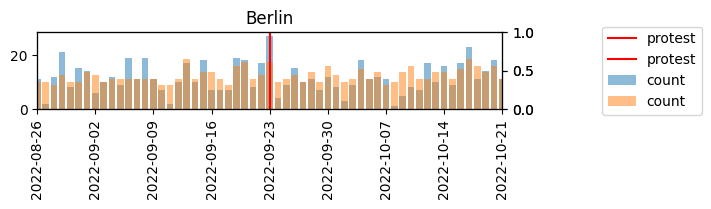

2.880445396911833 intercept
0.06878272304544418 Bayern
0.0 Brandenburg
0.0 Bremen
0.025643625144089247 Hessen
0.1554110789910582 Niedersachsen
0.0 Rheinland-Pfalz
0.0 Saarland
-0.0 Sachsen
0.0 Sachsen-Anhalt
-0.0 Thüringen


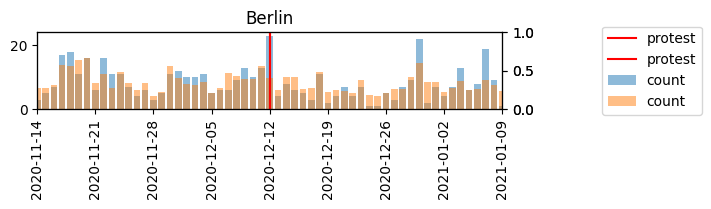

4.4446270128163 intercept
0.008215576733486687 Brandenburg
-0.0 Bremen
0.0 Saarland
0.0 Sachsen-Anhalt
0.0 Schleswig-Holstein
-0.0 Thüringen


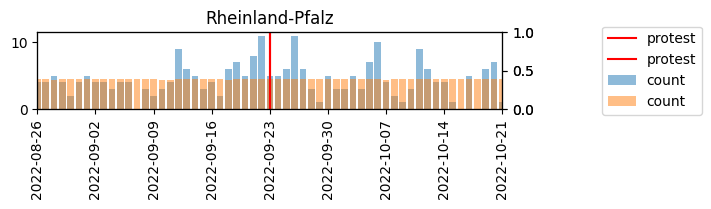

In [10]:
def synthetic_region(df):
    protest_region = df[df["is_protest_region"]]["region"].unique()[0]
    df = df.pivot(index="date", columns="region", values="count")
    df = df.reset_index()
    split = math.floor(len(df) / 2)
    train = df.iloc[:split]
    test = df.iloc[split:]
    len(train), len(test)

    Y_train = train[protest_region]
    X_train = train.drop(columns=[protest_region, "date"])

    model = Lasso()
    model.fit(X_train, Y_train)
    # print intercept and coefficients (annotated with region names)
    print(model.intercept_, "intercept")
    for region, coef in zip(X_train.columns, model.coef_):
        print(coef, region)
    df["synth"] = model.predict(df.drop(columns=[protest_region, "date"]))
    fig, ax = plt.subplots(figsize=(6, 1))
    df_region = (
        df[["date", protest_region]].copy().rename(columns={protest_region: "count"})
    )
    plot_coverage_sequence(df_region, title=protest_region, ax=ax, alpha=0.5)
    df_synth = df[["date", "synth"]].copy().rename(columns={"synth": "count"})
    plot_coverage_sequence(df_synth, ax=ax, alpha=0.5)
    plt.show()


for df in dfs:
    synthetic_region(df)